In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
import cv2

# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

# Define font properties for plots (initial setup, may be overridden later)
font = {'family':'DejaVu Sans',
        'weight':'normal',
        'size':10,
       }
label_font_size = 13 # A more descriptive name for 'labsize'

Mounted at /content/drive


In [2]:
# This cell defines several functions used for calculating lengths, finding points.

def calculate_path_length(coordinates):
    """
    Calculates the cumulative length along a path defined by a series of points.

    Args:
        coordinates (np.array): An array of points (x,y coordinates) that define the path.

    Returns:
        tuple: A tuple containing a list of cumulative lengths for each segment
               and the total length of the path.
    """
    cumulative_lengths = []  # List to store cumulative lengths
    total_length = 0       # Initialize total length

    # Iterate through the points to calculate the distance between each point and the next
    for i in range(1, len(coordinates)):
        # Calculate the Euclidean distance between consecutive points and add to the total length
        segment_length = np.linalg.norm(coordinates[i, :] - coordinates[i-1, :])
        total_length += segment_length
        cumulative_lengths.append(total_length)  # Append the cumulative length to the list
    return cumulative_lengths, total_length

def get_contour_points(contour_coords, centerline_coords, centerline_direction_vectors):
    """
    Finds the two corresponding points on a cell contour ('contour_coords') for each point
    on a centerline ('centerline_coords'). These corresponding points are generally
    perpendicular to the centerline at each centerline point, defining a 'width' across the cell.

    Args:
        contour_coords (np.array): Nx2 array of (x,y) coordinates defining the cell contour.
        centerline_coords (np.array): Mx2 array of (x,y) coordinates defining the cell centerline.
        centerline_direction_vectors (np.array): (M-1)x2 array of direction vectors along the centerline.

    Returns:
        tuple: A tuple containing:
            - np.array: The reordered contour points, starting from the point closest
                        to the beginning of the centerline.
            - np.array: An (M-1)x2 array where each row contains the indices of the
                        two corresponding contour points for a given centerline segment.
    """
    # Calculate the vector from each contour point to the start and end of the centerline
    # This helps in aligning the contour with the centerline's direction
    vec_to_start_center = contour_coords - centerline_coords[0, :]
    vec_to_end_center = contour_coords - centerline_coords[-1, :]

    # Find the indices of the contour points closest to the start and end of the centerline
    start_contour_idx = np.argmin(np.linalg.norm(vec_to_start_center, axis=1))
    end_contour_idx = np.argmin(np.linalg.norm(vec_to_end_center, axis=1))

    # Reorder (roll) the contour points so that the point closest to the start of the
    # centerline is at the beginning of the array. This ensures consistent processing.
    contour_coords = np.roll(contour_coords, -start_contour_idx, axis=0)

    # Re-calculate the end_contour_idx after rolling, adjusting for circular indexing
    # This ensures that 'end_contour_idx' now correctly reflects the position
    # of the original end point within the new 'contour_coords' array.
    end_contour_idx = (end_contour_idx - start_contour_idx + len(contour_coords)) % len(contour_coords)

    # Initialize an array to store the indices of the two corresponding points on the contour
    # for each segment of the centerline.
    corresponding_contour_indices = np.zeros(centerline_direction_vectors.shape)

    # For each segment of the centerline (defined by centerline_coords[i] and centerline_coords[i+1]),
    # find the two points on the contour that are most perpendicular to the centerline segment's
    # direction vector. These points define the width of the cell at that centerline position.
    for i in range(1, len(centerline_coords)):
        perpendicular_distances = []
        # Vector from each contour point to the current centerline point
        vec_to_centerline_point = contour_coords - centerline_coords[i, :]
        for j in range(len(vec_to_centerline_point)):
            # Calculate the absolute value of the dot product. A smaller dot product
            # indicates a more perpendicular relationship between the contour vector
            # and the centerline direction vector.
            perpendicular_distances.append(abs(np.dot(vec_to_centerline_point[j, :], centerline_direction_vectors[i-1, :])))

        # Find the indices of the two points on the contour with the minimum dot product.
        # The contour is split into two halves based on 'end_contour_idx' to find points
        # on opposite sides of the centerline.
        corresponding_contour_indices[i-1, 0] = np.argmin(perpendicular_distances[0 : end_contour_idx])
        corresponding_contour_indices[i-1, 1] = np.argmin(perpendicular_distances[end_contour_idx:]) + end_contour_idx
    return contour_coords, corresponding_contour_indices

def linear_interpolate(point1_coords, point2_coords, num_interpolation_points):
    """
    Performs linear interpolation between two given points to generate a specified
    number of intermediate points.

    Args:
        point1_coords (list or np.array): The (x,y) coordinates of the first point.
        point2_coords (list or np.array): The (x,y) coordinates of the second point.
        num_interpolation_points (int): The number of points to generate between
                                        point1_coords and point2_coords (inclusive of endpoints).

    Returns:
        np.array: An array of N interpolated points, where N is num_interpolation_points.
                  Each row is an (x,y) coordinate.
    """
    # Generate N evenly spaced x-coordinates between the x-coordinates of the two points.
    interp_x = np.linspace(point1_coords[0], point2_coords[0], num_interpolation_points)
    # Create a 1D interpolation function for the y-coordinates based on the x-coordinates of the two points.
    interpolation_function_1d = interpolate.interp1d([point1_coords[0], point2_coords[0]],
                                                     [point1_coords[1], point2_coords[1]])
    # Use the 1D interpolation function to find the corresponding y-coordinates for the
    # generated x-coordinates.
    interp_y = interpolation_function_1d(interp_x)
    # Stack the x and y coordinates vertically and then transpose to get an Nx2 array.
    return np.vstack((interp_x, interp_y)).T

In [3]:
# Define paths and parameters for data loading and processing

# Base directory for all data, assumed to be in Google Drive
data_dir = "./drive/MyDrive/Colab Notebooks/3. kymograph/"

# Base filename for the sample images and data files
base_filename = "sample01_best_230921_2228-2463Col_ory1_T20,Z31,zo4.2,512,Dw2,av1,la3_930_crop2"

# Image dimensions in pixels
image_height = 512
image_width = 512

# Number of time frames (images) to process
num_time_frames = 67

# Conversion factor from pixels to micrometers (um/pixel)
pixels_per_micron = 1 / 4.8697

# Subdirectories for different types of image data and processed files
image_dir = "0. images"            # Directory for raw image files (e.g., .png)
centerline_dir = "1. centerline"   # Directory for centerline coordinates (e.g., .txt)
contour_dir = "2. contour"         # Directory for contour coordinates (e.g., .txt)
intensity_dist_dir = "3. intensity distribution" # Directory to save processed intensity data

In [5]:
# Parameters for extending the centerline
max_cell_length_um = 90  # Maximum desired cell length in micrometers for consistent kymograph
dead_zone_bottom_um = 5  # Length to extend the bottom of the centerline (e.g., for 'dead' zone) in micrometers

# Create coordinate grids for image interpolation
x_coords_grid = np.linspace(0, image_width - 1, image_width)
y_coords_grid = np.linspace(0, image_height - 1, image_height)

# Initialize lists to store processed data for all frames
all_frame_intensities = [] # Stores intensity distributions along the extended centerlines
extended_centerline_lengths = [] # Stores cumulative lengths for the extended centerlines

# Loop through each time frame to process image data
for frame_idx in range(0, num_time_frames):
    # Construct the path to the current image file
    image_path = data_dir + image_dir + "/" + base_filename + "_" + "%03d" % frame_idx + ".png"
    # Load the image in grayscale
    image_data = cv2.imread(image_path, 0)

    # Create an interpolator for the image intensity. This allows querying
    # intensity values at non-integer pixel coordinates.
    # The order of (y,x) in RegularGridInterpolator is important; it expects (rows, columns).
    image_interpolator = RegularGridInterpolator((y_coords_grid, x_coords_grid), image_data)

    # Construct the path to the current contour file
    contour_path = data_dir + contour_dir + "/" + base_filename + "_" + "%03d" % frame_idx + ".txt"
    # Load the contour coordinates (assuming Y, X order in file)
    contour_coords_loaded = np.loadtxt(contour_path)

    # Construct the path to the current centerline file
    centerline_path = data_dir + centerline_dir + "/" + base_filename + "_" + "%03d" % frame_idx + ".txt"
    # Load the centerline coordinates (assuming Y, X order in file)
    centerline_coords_loaded = np.loadtxt(centerline_path)

    # Calculate the cumulative and total length of the loaded centerline (in micrometers)
    centerline_cum_lengths_um, total_centerline_length_um = calculate_path_length(centerline_coords_loaded * pixels_per_micron)

    # --- Centerline Extension (Bottom and Tip) ---
    # This section extends the centerline beyond the detected start and end points
    # to ensure a consistent length for kymograph generation across all frames.

    num_smoothing_points = 10 # Number of points to average for direction vector calculation

    # Calculate average direction vector for extending the bottom of the centerline
    # This averages the vectors of the first 'num_smoothing_points' segments
    bottom_extension_vec = np.zeros((1, 2))
    for j in range(num_smoothing_points):
        segment_vec = (centerline_coords_loaded[j+1, :] - centerline_coords_loaded[j, :])
        bottom_extension_vec -= segment_vec / np.linalg.norm(segment_vec) / num_smoothing_points # Negative for backward direction

    # Calculate average direction vector for extending the tip of the centerline
    # This averages the vectors of the last 'num_smoothing_points' segments
    top_extension_vec = np.zeros((1, 2))
    for j in range(num_smoothing_points):
        segment_vec = (centerline_coords_loaded[-1-j, :] - centerline_coords_loaded[-1-j-1, :])
        top_extension_vec += segment_vec / np.linalg.norm(segment_vec) / num_smoothing_points # Positive for forward direction

    # Calculate the distance needed to extend the tip to reach `max_cell_length_um`
    # after accounting for the initial centerline length and the bottom extension.
    # The division by `pixels_per_micron` converts micrometers to pixels.
    tip_extension_distance_pixels = (max_cell_length_um - total_centerline_length_um - dead_zone_bottom_um) / pixels_per_micron

    # Calculate the extended bottom and tip coordinates
    extended_bottom_coord = centerline_coords_loaded[0, :] + bottom_extension_vec * (dead_zone_bottom_um / pixels_per_micron) # Convert um to pixels
    extended_top_coord = centerline_coords_loaded[-1, :] + top_extension_vec * tip_extension_distance_pixels


    # Interpolate points for the extended bottom part of the centerline
    # Choose interpolation direction based on the larger coordinate difference to avoid vertical/horizontal line issues
    if np.abs(extended_bottom_coord[0, 0] - centerline_coords_loaded[0, 0]) > np.abs(extended_bottom_coord[0, 1] - centerline_coords_loaded[0, 1]):
        interpolation_function_1d = interpolate.interp1d([extended_bottom_coord[0, 0], centerline_coords_loaded[0, 0]],
                                                         [extended_bottom_coord[0, 1], centerline_coords_loaded[0, 1]], kind='slinear')
        interp_x = np.linspace(extended_bottom_coord[0, 0], centerline_coords_loaded[0, 0], 50) # 50 points for interpolation
        interp_y = interpolation_function_1d(interp_x)
        interpolated_bottom_centerline = np.vstack([interp_x, interp_y]).T
    else:
        interpolation_function_1d = interpolate.interp1d([extended_bottom_coord[0, 1], centerline_coords_loaded[0, 1]],
                                                         [extended_bottom_coord[0, 0], centerline_coords_loaded[0, 0]], kind='slinear')
        interp_y = np.linspace(extended_bottom_coord[0, 1], centerline_coords_loaded[0, 1], 50)
        interp_x = interpolation_function_1d(interp_y)
        interpolated_bottom_centerline = np.vstack([interp_x, interp_y]).T

    # Interpolate points for the extended tip part of the centerline
    if np.abs(extended_top_coord[0, 0] - centerline_coords_loaded[-1, 0]) > np.abs(extended_top_coord[0, 1] - centerline_coords_loaded[-1, 1]):
        interpolation_function_1d = interpolate.interp1d([centerline_coords_loaded[-1, 0], extended_top_coord[0, 0]],
                                                         [centerline_coords_loaded[-1, 1], extended_top_coord[0, 1]], kind='slinear')
        interp_x = np.linspace(centerline_coords_loaded[-1, 0], extended_top_coord[0, 0], 50)
        interp_y = interpolation_function_1d(interp_x)
        interpolated_tip_centerline = np.vstack([interp_x, interp_y]).T
    else:
        interpolation_function_1d = interpolate.interp1d([centerline_coords_loaded[-1, 1], extended_top_coord[0, 1]],
                                                         [centerline_coords_loaded[-1, 0], extended_top_coord[0, 0]], kind='slinear')
        interp_y = np.linspace(centerline_coords_loaded[-1, 1], extended_top_coord[0, 1], 50)
        interp_x = interpolation_function_1d(interp_y)
        interpolated_tip_centerline = np.vstack([interp_x, interp_y]).T

    # Plotting for visualization (optional, good for debugging)
    fig, ax = plt.subplots(figsize=(5, 5), sharex=True, sharey=True)
    plt.plot(contour_coords_loaded[:, 0], contour_coords_loaded[:, 1], label='Original Contour')
    plt.plot(centerline_coords_loaded[:, 0], centerline_coords_loaded[:, 1], label='Original Centerline')
    plt.plot(interpolated_bottom_centerline[:, 0], interpolated_bottom_centerline[:, 1], 'r', label='Extended Bottom')
    plt.plot(interpolated_tip_centerline[:, 0], interpolated_tip_centerline[:, 1], 'b', label='Extended Tip')
    plt.plot(interpolated_bottom_centerline[0, 0], interpolated_bottom_centerline[0, 1], 'xr', label='Start Extended Bottom')
    plt.plot(interpolated_tip_centerline[-1, 0], interpolated_tip_centerline[-1, 1], 'ob', label='End Extended Tip')
    plt.title(f'Frame={frame_idx:04d}', fontsize=15)
    plt.axis('square')
    plt.legend()
    plt.show()

    # --- Intensity Profile Extraction ---
    # This section extracts intensity profiles along the extended centerline and
    # across the cell width, perpendicular to the centerline.

    # Lists to store intensity measurements and their corresponding centerline positions
    current_frame_intensities = [] # Stores intensity values
    current_frame_positions_um = [] # Stores corresponding cumulative lengths in um

    # Process intensities for the extended bottom part of the centerline
    bottom_cum_lengths_um, bottom_total_length_um = calculate_path_length(interpolated_bottom_centerline * pixels_per_micron)
    # Get intensities along the interpolated bottom centerline
    bottom_interp_intensities = image_interpolator(interpolated_bottom_centerline)

    for point_idx in range(len(bottom_cum_lengths_um)):
        # Append the intensity and corresponding length (in um)
        current_frame_intensities.append(bottom_interp_intensities[point_idx])
        current_frame_positions_um.append(bottom_cum_lengths_um[point_idx])

    # Adjust cumulative lengths of the original centerline to account for the extended bottom
    centerline_cum_lengths_um = np.array(centerline_cum_lengths_um) + bottom_total_length_um

    # Calculate direction vectors for the original centerline segments
    # These vectors are used to find perpendicular lines for width intensity profiles
    centerline_diff_vectors = centerline_coords_loaded[1:len(centerline_coords_loaded), :] - centerline_coords_loaded[0:len(centerline_coords_loaded)-1, :]

    # Find corresponding contour points for each centerline point
    # These points will be used to define cross-sections for intensity measurement
    processed_contour_coords, corresponding_contour_indices = get_contour_points(contour_coords_loaded, centerline_coords_loaded, centerline_diff_vectors)

    # Process intensities across the cell width (perpendicular to centerline)
    # Iterate through each centerline segment
    for point_idx in range(len(corresponding_contour_indices)):
        # Get the two contour points corresponding to the current centerline segment
        # These points define a line across the cell's width
        p1_idx = int(corresponding_contour_indices[point_idx, 0])
        p2_idx = int(corresponding_contour_indices[point_idx, 1])

        # Interpolate 100 points between these two contour points to create a cross-section line
        interp_contour_points = linear_interpolate(processed_contour_coords[p1_idx, :], processed_contour_coords[p2_idx, :], 100)

        # Get intensity values along this cross-section line from the image interpolator
        contour_cross_section_intensities = image_interpolator(interp_contour_points)

        # Append the maximum intensity found in this cross-section (or mean if positive)
        # This is a common way to estimate "nuclear" intensity or peak intensity along the width
        current_frame_intensities.append(np.max([np.mean(contour_cross_section_intensities[contour_cross_section_intensities > 0]), 0]))

        # Append the corresponding cumulative length of the centerline point
        current_frame_positions_um.append(centerline_cum_lengths_um[point_idx])

    # Process intensities for the extended tip part of the centerline
    tip_cum_lengths_um, tip_total_length_um = calculate_path_length(interpolated_tip_centerline * pixels_per_micron)
    # Adjust cumulative lengths of the extended tip to continue from the last point
    tip_cum_lengths_um = tip_cum_lengths_um + current_frame_positions_um[-1]

    # Get intensities along the interpolated tip centerline
    tip_interp_intensities = image_interpolator(interpolated_tip_centerline)

    for point_idx in range(len(tip_cum_lengths_um)):
        current_frame_intensities.append(tip_interp_intensities[point_idx])
        current_frame_positions_um.append(tip_cum_lengths_um[point_idx])

    # Save the intensity profile for the current frame
    # The saved data will have two columns: [intensity, cumulative_length_um]
    save_intensity_path = data_dir + intensity_dist_dir + "/" + "%04d" % frame_idx + ".txt"
    np.savetxt(save_intensity_path, np.array([current_frame_intensities, current_frame_positions_um]).T)

# Print a message indicating completion of the frame processing loop
print("All frames processed.")

Output hidden; open in https://colab.research.google.com to view.

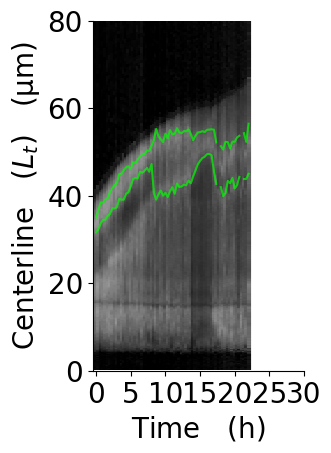

In [9]:
# Plot kymograph

import seaborn as sns
from matplotlib.collections import LineCollection

# Directory for microtubule (MT) band position and width data
mt_band_dir = '4. MTs_band  Position and Width'

# Initialize a list to store all intensity profiles loaded from files for kymograph plotting
all_frame_intensities = []

# Initialize variables for the minimum and maximum Y-axis (length) values in the kymograph
kymo_y_min = 0 # Initialized to 0, will be updated to the true minimum observed length
kymo_y_max = 0 # Initialized to 0, will be updated to the true maximum observed length

# Lists to store the upper and lower boundaries of the microtubule band over time
mt_band_upper_boundary = np.zeros((num_time_frames, 2))
mt_band_lower_boundary = np.zeros((num_time_frames, 2))

# Loop through each time frame to load intensity and MT band data
for frame_idx in range(0, num_time_frames):
  # Construct the path to the intensity distribution file for the current frame
  intensity_file_path = data_dir + intensity_dist_dir + "/" + "%04d" % frame_idx + ".txt"
  # Load the intensity data (intensity, cumulative length) for the current frame
  current_frame_data = np.loadtxt(intensity_file_path)
  all_frame_intensities.append(current_frame_data)

  # Update the minimum and maximum observed lengths across all frames
  kymo_y_min = max([kymo_y_min, np.min(all_frame_intensities[-1][:, 1])]) # Note: This seems to track the max of min, likely a typo should be min
  kymo_y_max = max([kymo_y_max, np.max(all_frame_intensities[-1][:, 1])])

  # Construct the path to the MT band data file for the current frame
  mt_band_path = data_dir + mt_band_dir + "/" + base_filename + "_" + "%03d" % frame_idx + ".txt"
  # Load the MT band data (mean position, width)
  mt_band_data = np.loadtxt(mt_band_path)

  # Calculate and store the upper and lower boundaries of the MT band
  # The factor of 1 is likely meant to be the number of standard deviations for the band width
  mt_band_upper_boundary[frame_idx, :] = [min(mt_band_data[0] + mt_band_data[1] / 1, all_frame_intensities[frame_idx][-1, 1]), frame_idx]
  mt_band_lower_boundary[frame_idx, :] = [mt_band_data[0] - mt_band_data[1] / 1, frame_idx]


# Define font size for labels
label_font_size = 20

# Define font properties for matplotlib plots
font = {'family':'DejaVu Sans',
        'weight':'normal',
        'size':label_font_size - 5,
       }
plt.rc('font', **font) # Apply font settings globally

# Step size for the x-axis (time) in the kymograph.
# This scales the frame index to represent time progression visually.
kymo_x_step = 1

# Line width for plotting intensity profiles in the kymograph
line_width = 3.0

# Maximum intensity value for colormap normalization (e.g., 8-bit image max)
max_intensity_value = 255

# --- Kymograph Plotting ---
# Create a figure and a single subplot for the kymograph
fig = plt.figure(figsize=(6, 10))
kymograph_ax = fig.add_subplot(221) # Creates a 2x2 grid of subplots and selects the first one

# Define colormap normalization. This maps intensity values (0-255) to the colormap.
colormap_norm = plt.Normalize(0, max_intensity_value)

# Iterate through each frame's intensity data to plot individual intensity profiles
# as vertical lines in the kymograph. The color of each line segment represents intensity.
for i in range(len(all_frame_intensities)):
    plot_y = all_frame_intensities[i][:, 1] # Cumulative length (um) as Y-coordinate
    plot_x = np.zeros(len(plot_y)) + i * kymo_x_step # Time (frame_idx * step) as X-coordinate
    plot_z = all_frame_intensities[i][:, 0] # Intensity as Z-coordinate (for color mapping)

    # Reshape data for LineCollection.
    # points: Nx1x2 array (each point is (x,y))
    # segments: (N-1)x2x2 array (each segment is [(x1,y1), (x2,y2)])
    points = np.array([plot_x, plot_y]).T.reshape(-1, 1, 2)
    line_segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection. This is efficient for plotting many line segments
    # with varying colors (based on 'plot_z' which is intensity).
    line_collection = LineCollection(line_segments, cmap="gray", norm=colormap_norm)
    line_collection.set_array(plot_z)       # Set intensity values for color mapping
    line_collection.set_linewidth(line_width) # Set line width
    kymo_line_obj = kymograph_ax.add_collection(line_collection) # Add to the plot

# Plot the calculated upper and lower boundaries of the MT band
# `mt_band_upper_boundary[:, 1]` is the frame index (X-axis)
# `mt_band_upper_boundary[:, 0] + dead_zone_bottom_um` is the length (Y-axis), adjusting for bottom extension
kymograph_ax.plot(mt_band_upper_boundary[:, 1], mt_band_upper_boundary[:, 0] + dead_zone_bottom_um,
                   'lime', linestyle='solid', alpha=0.7, label=r'MT Band $\mu + \sigma$')
kymograph_ax.plot(mt_band_lower_boundary[:, 1], mt_band_lower_boundary[:, 0] + dead_zone_bottom_um,
                   'lime', linestyle='solid', alpha=0.7, label=r'MT Band $\mu - \sigma$')


# Optional: Plot a vertical dashed line (commented out in original)
# plt.plot([am[fi],am[fi]],[0,np.max(mMTs[-1][:,1])+5],'k--',alpha = 0.5)

# Set X-axis limits for the kymograph
kymograph_ax.set_xlim(-1.5, len(all_frame_intensities) + 0.5)

# Set Y-axis limits for the kymograph. Using a fixed limit for consistency.
# Original: axs1.set_ylim(0, np.max(mMTs[-1][:,1])+5)
kymograph_ax.set_ylim(0, 80) # Fixed Y-limit in micrometers

# Set X-axis tick labels to represent time in hours
# Original ticks were [0,15,30,45,60,75,90] frames. Assuming 20 frames/hour.
kymograph_ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
kymograph_ax.set_xticklabels([0, int(15 * 20 / 60), int(30 * 20 / 60), int(45 * 20 / 60),
                               int(60 * 20 / 60), int(75 * 20 / 60), int(90 * 20 / 60)])
kymograph_ax.set_xlabel(r'$\mathrm{Time} \quad (\mathrm{h})$', fontsize=label_font_size)

# Set Y-axis label for centerline length
kymograph_ax.set_ylabel(r'$\mathrm{Centerline} \quad (L_{t}) \quad \mathrm{(\mu m)}$', fontsize=label_font_size)

# Set tick parameters (font size) for both axes
kymograph_ax.tick_params(labelsize=label_font_size)

# Remove the top and right spines from the plot for a cleaner look
sns.despine(ax=kymograph_ax)

# Display the generated kymograph plot
plt.show()